In [1]:
import pandas as pd
import numpy as np
# 데이터 시각화
import matplotlib.pyplot as plt
from matplotlib import rc

# 모델
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split
# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')


# 한글 폰트 깨지지 않게 하기
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기 및 정제

In [2]:
raw_data = pd.read_csv("../../01.files/02.Bigsata_analysis/보험료.csv", encoding = 'euc-kr')
raw_data.head()

,고객번호,성별,나이,BMI,자녀수,흡연여부,가입유형,납부유형,보장범위,납입기간,보험료
0,ID100001,남성,19,27.9,0,1,홈쇼핑,은행,19,40,168849
1,ID100002,여성,18,33.8,1,0,인터넷,은행,10,40,17255
2,ID100003,여성,28,33.0,3,0,상담사,카드,12,30,44494
3,ID100004,여성,33,22.7,0,0,홈쇼핑,지로,15,30,219844
4,ID100005,여성,32,28.9,0,0,인터넷,카드,9,30,38668


In [3]:
raw_data.dropna(inplace = True)
raw_data.drop(['고객번호'], axis = 1, inplace = True)
df = pd.get_dummies(raw_data)
df.head()

,나이,BMI,자녀수,흡연여부,보장범위,납입기간,보험료,성별_남성,성별_여성,가입유형_상담사,가입유형_인터넷,가입유형_홈쇼핑,납부유형_은행,납부유형_지로,납부유형_카드
0,19,27.9,0,1,19,40,168849,1,0,0,0,1,1,0,0
1,18,33.8,1,0,10,40,17255,0,1,0,1,0,1,0,0
2,28,33.0,3,0,12,30,44494,0,1,1,0,0,0,0,1
3,33,22.7,0,0,15,30,219844,0,1,0,0,1,0,1,0
4,32,28.9,0,0,9,30,38668,0,1,0,1,0,0,0,1


In [7]:
# formula 텍스트 만드는 함수

def make_formula_txt(column_list, y_value):
    y_index = column_list.index(y_value)
    formula_text = column_list[y_index] + " ~ "
    x_list = column_list.copy()
    x_list.remove(y_value)
    #print(x_list)
    for i in range(1, len(x_list)):
        formula_text += x_list[i] + "+"
    formula_text = formula_text[:-1]
    formula_text
    
    return formula_text

In [6]:
df_x = df.drop(['보험료'], axis = 1, inplace=False)
df_y = df['보험료']

df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 777)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size=0.3, random_state=777)
print("train, test:", df_train.shape, df_test.shape)
print("df_train_x:",df_train_x.shape)
print("df_test_x:",df_test_x.shape)
print("df_train_y:",df_train_y.shape)
print("df_test_y:",df_test_y.shape)

train, test: (936, 15) (402, 15)
df_train_x: (936, 14)
df_test_x: (402, 14)
df_train_y: (936,)
df_test_y: (402,)


In [9]:
# 회귀 모델
column_list = ['보험료', 'BMI', '성별_여성', '흡연여부', '보장범위', '나이', '납입기간']
formula_text = make_formula_txt(column_list, '보험료')

lr_model = smf.ols(formula=formula_text, data = df_train)
lr_result = lr_model.fit()
print(lr_result.summary())

# Decision tree
dt_model = DecisionTreeRegressor(random_state=777,  
                                 min_samples_leaf=3, 
                                 min_samples_split=12, 
                                 max_depth = 8)
dt_model.fit(df_train_x, df_train_y)

# Random Forest
rf_model = RandomForestRegressor(random_state=777, 
                                 n_estimators = 20, 
                                 min_samples_leaf = 1,
                                 min_samples_split = 2, 
                                 max_depth = 9)

rf_model.fit(df_train_x, df_train_y)

#GB

gb_model = GradientBoostingRegressor(random_state = 777,
                                    n_estimators= 120,
                                    min_samples_leaf= 10,
                                    min_samples_split= 24,
                                    max_depth= 7,
                                    learning_rate= 0.04)
gb_model.fit(df_train_x, df_train_y)

                            OLS Regression Results                            
Dep. Variable:                    보험료   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     749.4
Date:                Wed, 19 Mar 2025   Prob (F-statistic):          3.46e-323
Time:                        12:59:09   Log-Likelihood:                -11522.
No. Observations:                 936   AIC:                         2.306e+04
Df Residuals:                     930   BIC:                         2.308e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.317e+04   2.29e+04      1.886      0.0

GradientBoostingRegressor(learning_rate=0.04, max_depth=7, min_samples_leaf=10,
                          min_samples_split=24, n_estimators=120,
                          random_state=777)

In [10]:
# model List
models = ["회귀분석", "의사결정나무", "랜덤 포레스트", "그래디언트 부스팅"]
mse, rmse, mae, mape = [],[],[],[]

# 회귀분석예측
lr_y_pred = lr_result.predict(df_test)

# 평가
mse.append(mean_squared_error(df_test['보험료'], lr_y_pred))
rmse.append(mean_squared_error(df_test['보험료'], lr_y_pred, squared=False))
mae.append(mean_absolute_error(df_test['보험료'], lr_y_pred))
mape.append(mean_absolute_percentage_error(df_test['보험료'], lr_y_pred))

# 의사결정나무예측
dt_y_pred = dt_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, dt_y_pred))
rmse.append(mean_squared_error(df_test_y, dt_y_pred, squared=False))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, dt_y_pred))

# 랜덤포레스트예측
rf_y_pred = rf_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(mean_squared_error(df_test_y, rf_y_pred, squared=False))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

# 그래디언트부스팀예측
gb_y_pred = gb_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(mean_squared_error(df_test_y, gb_y_pred, squared=False))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

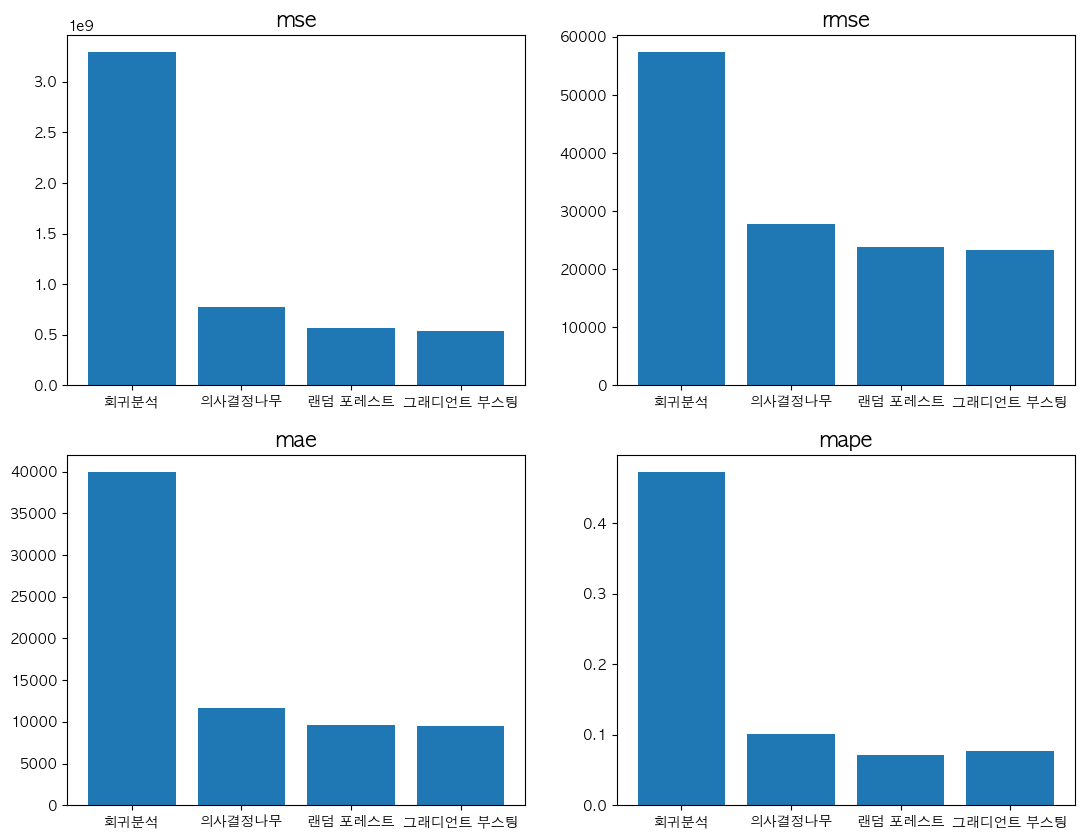

In [11]:
fig, ax = plt.subplots(2,2, figsize = (13,10))
ax[0, 0].bar(models, mse)
ax[0, 0].set_title("mse").set_fontsize(15)

ax[0, 1].bar(models, rmse)
ax[0, 1].set_title("rmse").set_fontsize(15)

ax[1, 0].bar(models, mae)
ax[1, 0].set_title("mae").set_fontsize(15)

ax[1, 1].bar(models, mape)
ax[1, 1].set_title("mape").set_fontsize(15)

### 결론
- 다른 트리기반 모델에 비하여 회귀분석 모델이 압도적으로 낮은 정확도를 보이며,        
  트리기반 모델중에서는 그래디언트 부스팅 모델의 정확도가 개중 가장 높게 나타난다.